## Imports

In [1]:
import os
import sys
import pathlib

import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
import albumentations as albu

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Fix to be able to import python modules inside a notebook
os.chdir('..')

# Useful extensions
# %load_ext watermark
# %watermark -v -n -m -p numpy,torch,albumentations,photosynthesis_metrics

# %load_ext autoreload
# %autoreload 2

# Nice plot formating
%matplotlib inline

In [3]:
!ls

configs  notebooks	README.md	  src		     train.py
data	 preprocess.py	requirements.txt  train_catalyst.py


## Explore data
### Train
- **68811** files in total
- **3097** folders with images

### Test A
- Number of queries: **9600**
- Library size: **49804**

### Test B
- Number of queries: **17092**
- Library size: **97547**

### Compute distribution of sizes

In [4]:
train = set(os.listdir("data/raw/train_data"))
train2 = set(os.listdir("data/interim/train_data_768"))
train - train2

{'DIGIX_000608',
 'DIGIX_000669',
 'DIGIX_000752',
 'DIGIX_000831',
 'DIGIX_001453',
 'DIGIX_001561',
 'DIGIX_001639',
 'DIGIX_002131',
 'DIGIX_002284',
 'label.txt'}

In [5]:
# from PIL import Image
# from tqdm.notebook import tqdm
# import multiprocessing
# NUM_THREADS = 8

# root = "data/raw"

# # Read file with labels
# with open(os.path.join(root, "train_data/label.txt")) as f:
#     data = f.readlines()

# filenames, targets = [], []
# for row in data:
#     path, label = row.strip("\n").split(",")
#     filenames.append(os.path.join(root, "train_data", path))
#     targets.append(int(label))


    
# def get_single_size(filename):
#     # use PIL to avoid reading image. it's much faster
#     return Image.open(filename).size, filename


# def get_sizes(filenames):
#     """Returns list of sizes for files in filenames"""
#     with multiprocessing.Pool(NUM_THREADS) as pool:
#         result = list(tqdm(pool.imap(get_single_size, filenames), total=len(filenames)))
#     return result

# train_result = get_sizes(filenames)
# test_A_result = get_sizes(test_A_files)
# test_B_result = get_sizes(test_B_files)

# plt.figure(figsize=(10,10))
# plt.title("Image sizes")
# plt.xlabel("Width")
# plt.ylabel("Heigth")

# H = [x[0][0] for x in test_B_result]
# W = [x[0][1] for x in test_B_result]
# plt.scatter(W, H, marker='.', c='g', alpha=0.03)

# H = [x[0][0] for x in train_result]
# W = [x[0][1] for x in train_result]
# plt.scatter(W, H, marker='.', c='b', alpha=0.03)

# H = [x[0][0] for x in test_A_result]
# W = [x[0][1] for x in test_A_result]
# plt.scatter(W, H, marker='*', c='r', alpha=0.03)


### View images

In [6]:
from src.datasets import ClassificationDataset, get_dataloaders

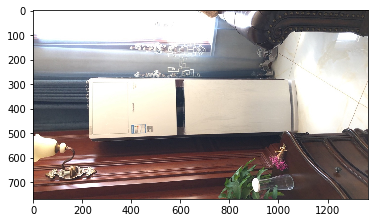

In [7]:
dataset = ClassificationDataset(root="data/interim", transform=None, train=False, size=768)
# plt.imshow(dataset[0][0])
# plt.subplot(1, 3, 3)
plt.imshow(dataset[1101][0].permute(2, 1, 0))

In [8]:
from src.augmentations import get_aug
import torchvision

train_loader, val_loader = get_dataloaders(
    root="data/interim",
    augmentation="hard",
    batch_size=9,
    size=768,
    val_size=768,
    workers=6,
)

2020-09-11 00:25:26.688 | INFO     | src.datasets:get_val_dataloader:82 - Val size: 13761
2020-09-11 00:25:26.692 | INFO     | src.datasets:get_dataloaders:58 - Train size: 68805


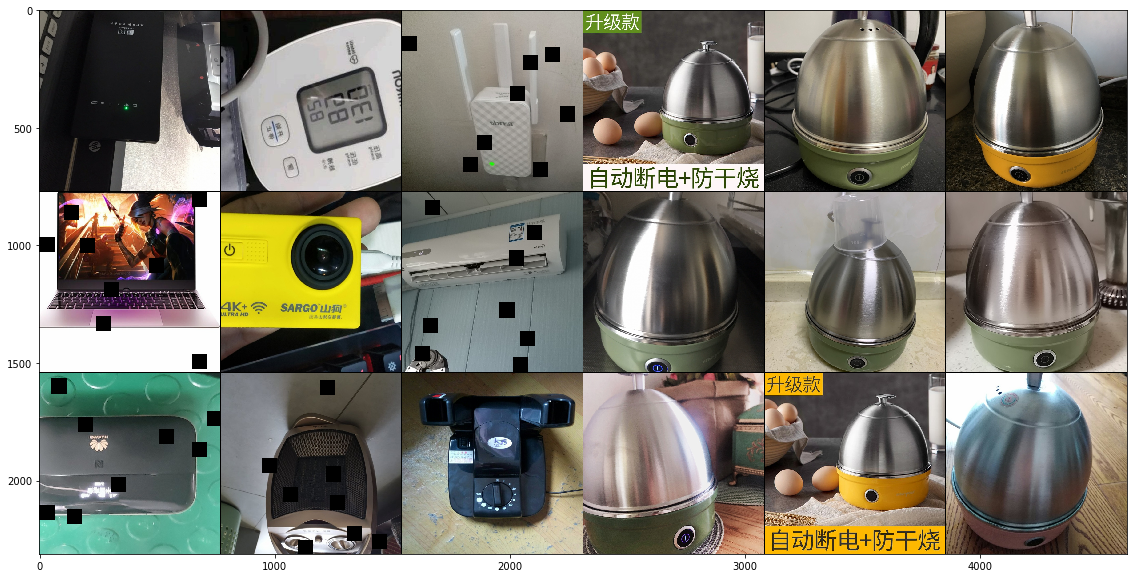

In [12]:
for batch in train_loader:
    train_images, labels = batch
    break

for batch in val_loader:
    val_images, labels = batch
    break
    

train_grid = torchvision.utils.make_grid(train_images, nrow=3, normalize=True, scale_each=True)
val_grid = torchvision.utils.make_grid(val_images, nrow=3, normalize=True, scale_each=True)
grid = torch.cat([train_grid, val_grid], dim=2)
plt.figure(figsize=(30, 10))
plt.imshow(grid.permute((1,2,0)).cpu())

In [17]:
len(torch.FloatTensor(10).uniform_() > 0.8)


10

## Implement metrics

### CMC score

In [76]:
import torch



In [88]:
NUM_EMBEDDINGS = 20
EMBEDDING_DIM = 4
NUM_CLASSES = 5

# All emb. I got from val loader
embeddings = torch.rand(NUM_EMBEDDINGS, EMBEDDING_DIM)
labels = torch.randint(low=0, high=NUM_CLASSES, size=(NUM_EMBEDDINGS,))


query_mask = torch.FloatTensor(len(embeddings)).uniform_() > 0.8

# Shape (n_embeddings, embedding_dim)
query_embeddings = embeddings[query_mask]
gallery_embeddings = embeddings[~query_mask]

query_labels = labels[query_mask]
gallery_labels = labels[~query_mask]
print(len(query_embeddings))

6


In [90]:
conformity_matrix = query_labels.reshape(-1, 1) == gallery_labels
print(conformity_matrix.shape)
conformity_matrix

cmc_score(query_embeddings, gallery_embeddings, conformity_matrix, topk=2)

torch.Size([6, 14])


0.6666666865348816